In [1]:
import findspark
findspark.init('/usr/hdp/current/spark2-client')

import pyspark
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import seaborn as sns
import pandas as pd
%matplotlib inline
from pyspark.sql.functions import lit, col, instr, expr, pow, round, bround, corr, count, mean, stddev_pop, min, max
from pyspark.sql.functions import monotonically_increasing_id, initcap, lower, upper, ltrim, rtrim, rpad, lpad, trim
from pyspark.sql.functions import regexp_replace, translate, regexp_extract, current_date, current_timestamp, struct
from pyspark.sql.functions import date_add, date_sub, datediff, months_between, to_date, to_timestamp, coalesce, split, size
from pyspark.sql.functions import array_contains, explode, udf
from pyspark.sql import HiveContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, when

from pyspark.sql.types import StructField, StructType, StringType, IntegerType, DoubleType, FloatType, LongType

In [2]:
def get_Spark():

    conf = pyspark.SparkConf().setAll([
        ('spark.submit.deployMode', 'client'), # deploy in yarn-client or yarn-cluster
        ('spark.executor.memory', '10g'),       # memory allocated for each executor
        ('spark.executor.cores', '10'),         # number of cores for each executor
        ('spark.executor.instances', '10'),    # number of executors in total
        ('spark.yarn.am.memory', '20g')])      # memory for spark driver (application master)
    spark = SparkSession.builder \
    .master("yarn") \
    .appName("sensor") \
    .enableHiveSupport() \
    .config(conf = conf) \
    .getOrCreate()

    return spark

spark = get_Spark()
spark_context = spark.sparkContext
hc = HiveContext(spark_context)

In [3]:
def hive2spark(hc, query):
    spark_df = hc.sql("""{}""".format(query))
    return spark_df

In [18]:
query="select * from a26_tsp_tbls.ge3_daily_temperature_sensor_status" #ge3_daily_temperature_sensor_filters
df_sensor = hc.sql(query).toPandas()
df_sensor.head()

,vin,error_code,sensor_ids,severity_level,day
0,LMGHP1S53J1003459,2,39,0.01,2018-12-28
1,LMGHP1S53J1003820,2,11|27,0.11,2018-12-28
2,LMGHP1S53J1003820,5,19|20,0.12,2018-12-28
3,LMGHP1S53J1004076,2,11|27,0.06,2018-12-28
4,LMGHP1S53J1004661,2,11|27,0.03,2018-12-28


In [19]:
import time
stime = time.time()  
def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
            
        for value in values:
            indexes.append(i)
            new_values.append(value)
            
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df
df_sensor = tidy_split(df_sensor, 'sensor_ids', sep='|', keep=False)
etime = time.time()
print "Finished in {} seconds".format(etime - stime)

Finished in 0.0893499851227 seconds


In [9]:
query="select * from guobiao_tsp_tbls.vintypes"
vintype_df = hc.sql(query).toPandas()
vintype_df.head()

,vin,vintype,start_day,latest_day
0,LMGGN1S56F1000483,AG.72,2018-11-08,2019-06-24
1,LMGGN1S52F1001114,AG.79,2018-11-08,2019-06-24
2,LMGGN1S50G1001761,AG.79,2019-06-01,2019-06-23
3,LMGFJ1S85H1S00176,A51,2017-08-10,2018-05-07
4,LMGAJ1S88H1S00215,A2APHEV,2017-08-07,2019-02-16


In [20]:
df = pd.merge(df_sensor, vintype_df, on='vin', how='inner')
df.head()

,vin,error_code,sensor_ids,severity_level,day,vintype,start_day,latest_day
0,LMGHP1S53J1003459,2,39,0.01,2018-12-28,A5HEV,2018-02-28,2020-07-15
1,LMGHP1S53J1003459,2,39,0.01,2018-12-08,A5HEV,2018-02-28,2020-07-15
2,LMGHP1S53J1003459,2,39,0.01,2018-12-30,A5HEV,2018-02-28,2020-07-15
3,LMGHP1S53J1003459,2,11,0.02,2019-12-31,A5HEV,2018-02-28,2020-07-15
4,LMGHP1S53J1003459,2,39,0.02,2019-12-31,A5HEV,2018-02-28,2020-07-15


In [21]:
df['vintype'].value_counts()

A5HEV    95305
A75      15354
Name: vintype, dtype: int64

In [22]:
df_for_a75 = df[df['vintype']=='A75']
df_for_a75.head()

,vin,error_code,sensor_ids,severity_level,day,vintype,start_day,latest_day
27062,LMWHP1S53J1000615,3,8,0.01,2019-12-24,A75,2018-09-11,2020-06-10
27063,LMWHP1S53J1000615,3,9,0.01,2019-12-24,A75,2018-09-11,2020-06-10
27064,LMWHP1S53J1000615,3,10,0.01,2019-12-24,A75,2018-09-11,2020-06-10
27065,LMWHP1S53J1000615,3,11,0.01,2019-12-24,A75,2018-09-11,2020-06-10
27066,LMWHP1S53J1000615,3,12,0.01,2019-12-24,A75,2018-09-11,2020-06-10


In [23]:
df_for_a5hev = df[df['vintype']=='A5HEV']
df_for_a5hev.head()

,vin,error_code,sensor_ids,severity_level,day,vintype,start_day,latest_day
0,LMGHP1S53J1003459,2,39,0.01,2018-12-28,A5HEV,2018-02-28,2020-07-15
1,LMGHP1S53J1003459,2,39,0.01,2018-12-08,A5HEV,2018-02-28,2020-07-15
2,LMGHP1S53J1003459,2,39,0.01,2018-12-30,A5HEV,2018-02-28,2020-07-15
3,LMGHP1S53J1003459,2,11,0.02,2019-12-31,A5HEV,2018-02-28,2020-07-15
4,LMGHP1S53J1003459,2,39,0.02,2019-12-31,A5HEV,2018-02-28,2020-07-15


In [24]:
sensor_dist_for_a75 = df_for_a75['sensor_ids'].value_counts()

In [25]:
sensor_dist_for_a75.head()

7     812
8     681
28    555
27    554
10    513
Name: sensor_ids, dtype: int64

In [26]:
sensor_dist_for_a5hev = df_for_a5hev['sensor_ids'].value_counts()

In [27]:
sensor_dist_for_a5hev.head()

unknown    10529
27          7462
39          7310
11          6585
15          5584
Name: sensor_ids, dtype: int64

In [28]:
sensor_dist_a5hev = pd.DataFrame(sensor_dist_for_a5hev).reset_index()

In [29]:
sensor_dist_a75 = pd.DataFrame(sensor_dist_for_a75).reset_index()

In [30]:
sensor_dist_a5hev.columns=['sensor','count']
sensor_dist_a75.columns=['sensor','count']

In [31]:
sensor_dist_a5hev = sensor_dist_a5hev.sort_index()
sensor_dist_a5hev = sensor_dist_a5hev.sort_values(['count'])
sensor_dist_a5hev = sensor_dist_a5hev[sensor_dist_a5hev['sensor']!='unknown']
sensor_dist_a5hev[['sensor']] = sensor_dist_a5hev[['sensor']].astype(int)

In [32]:
sensor_dist_a75 = sensor_dist_a75.sort_index()
sensor_dist_a75 = sensor_dist_a75.sort_values(['count'])
sensor_dist_a75 = sensor_dist_a75[sensor_dist_a75['sensor']!='unknown']
sensor_dist_a75[['sensor']] = sensor_dist_a75[['sensor']].astype(int)

[Text(0,0.5,'frequency'),
 Text(0.5,0,'sensor'),
 Text(0.5,1,'Abnormal Sensor Top Frequency (A75)')]

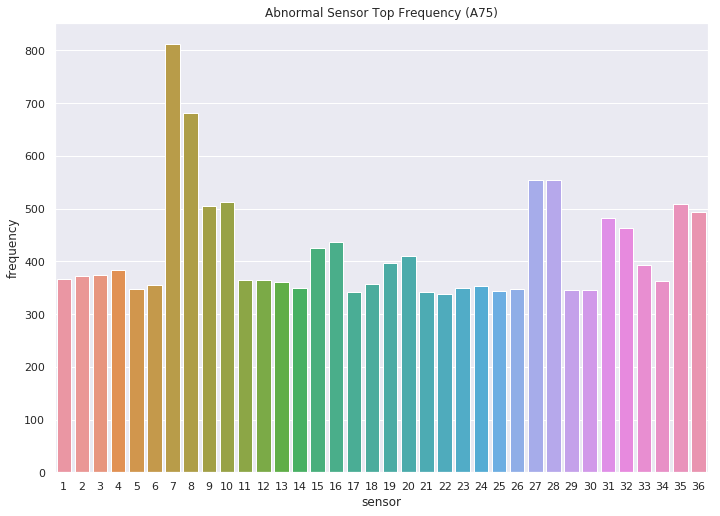

In [33]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="sensor", y="count", data=sensor_dist_a75)
ax.set(xlabel='sensor', ylabel='frequency', title='Abnormal Sensor Top Frequency (A75)')

[Text(0,0.5,'frequency'),
 Text(0.5,0,'sensor'),
 Text(0.5,1,'Abnormal Sensor Top Frequency (A5HEV)')]

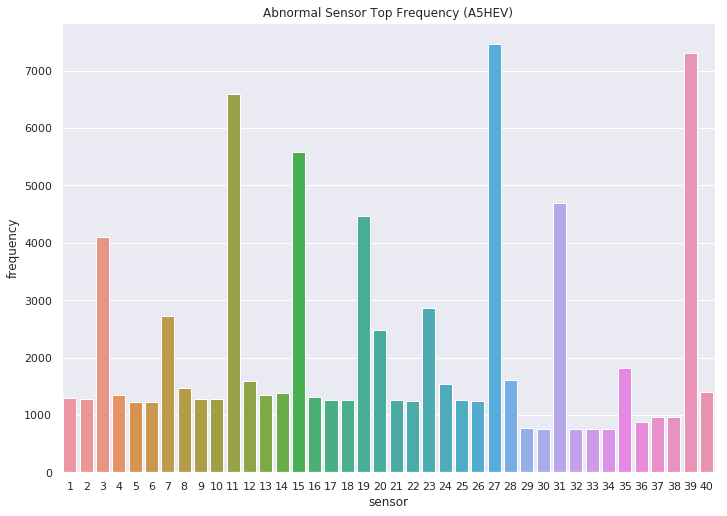

In [35]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="sensor", y="count", data=sensor_dist_a5hev)
ax.set(xlabel='sensor', ylabel='frequency', title='Abnormal Sensor Top Frequency (A5HEV)')

In [88]:
query2="select * from a26_tsp_tbls.a26_daily_temperature_sensor_status" #ge3_daily_temperature_sensor_filters
df_sensor = hc.sql(query2).toPandas()
df_sensor = tidy_split(df_sensor, 'sensor_ids', sep='|', keep=False)
df_sensor.head()

,vin,error_code,sensor_ids,severity_level,day
0,LNAA2AA1XK5019888,4,1,0.58,2020-06-17
0,LNAA2AA1XK5019888,4,2,0.58,2020-06-17
0,LNAA2AA1XK5019888,4,3,0.58,2020-06-17
0,LNAA2AA1XK5019888,4,4,0.58,2020-06-17
0,LNAA2AA1XK5019888,4,5,0.58,2020-06-17


In [83]:
query="select * from a26_tsp_tbls.vintypes"
vintype_df = hc.sql(query).toPandas()
vintype_df.head()

,vin,vintype,start_day,latest_day
0,LNAA2AA15K5027400,A26,2019-12-11,2020-06-22
1,LNAA3AA16L5400412,A26,2020-06-11,2020-06-22
2,LNAA2AA18L5046170,A26,2020-06-18,2020-06-22
3,LNAA2AA19K5027318,A26,2019-12-06,2020-06-22
4,LNAA2AA15L5045400,A26,2020-06-03,2020-06-22


In [69]:
query="select * from a26_tsp_tbls.numbers_voltage_cells"
number_of_cells_df = hc.sql(query).toPandas()
number_of_cells_df.head()

,vin,number_of_cells
0,LNAA2AA16K5900488,90
1,LNAA2AA1XK5003125,92
2,LNAB1AB3XL5502855,112
3,LNAA2AA14K5019904,90
4,LNAA2AA1XK5028963,90


In [70]:
number_of_cells_df["number_of_cells"] = number_of_cells_df["number_of_cells"].astype(int)

In [71]:
tmp = pd.merge(vintype_df.loc[vintype_df["vintype"].isin(['A26','A12'])], number_of_cells_df, on='vin', how='inner')

In [72]:
tmp["vintype"].value_counts()

A26    55842
A12     4260
Name: vintype, dtype: int64

In [73]:
tmp.dtypes

vin                object
vintype            object
start_day          object
latest_day         object
number_of_cells     int64
dtype: object

In [74]:
tmp["number_of_cells"] = tmp["number_of_cells"].astype(str)
tmp['vintype'] = tmp[['vintype', 'number_of_cells']].agg('_'.join, axis=1)
tmp.drop('number_of_cells', inplace=True, axis=1)
tmp.head()

,vin,vintype,start_day,latest_day
0,LNAA2AA15K5027400,A26_92,2019-12-11,2020-06-22
1,LNAA3AA16L5400412,A26_92,2020-06-11,2020-06-22
2,LNAA2AA18L5046170,A26_90,2020-06-18,2020-06-22
3,LNAA2AA19K5027318,A26_92,2019-12-06,2020-06-22
4,LNAA2AA15L5045400,A26_90,2020-06-03,2020-06-22


In [75]:
tmp.head()

,vin,vintype,start_day,latest_day
0,LNAA2AA15K5027400,A26_92,2019-12-11,2020-06-22
1,LNAA3AA16L5400412,A26_92,2020-06-11,2020-06-22
2,LNAA2AA18L5046170,A26_90,2020-06-18,2020-06-22
3,LNAA2AA19K5027318,A26_92,2019-12-06,2020-06-22
4,LNAA2AA15L5045400,A26_90,2020-06-03,2020-06-22


In [76]:
tmp['vintype'].value_counts()

A26_92     37051
A26_90     18758
A12_112     3363
A12_88       895
A26_102       33
A12_96         2
Name: vintype, dtype: int64

In [82]:
vintype_df['vintype'].value_counts()

A26     55842
A12      4260
NONE      220
Name: vintype, dtype: int64

In [ ]:
not2612_df = vintype_df.loc[~vintype_df.vintype.isin(['A26','A12'])]

In [85]:
vintype_df = tmp
vintype_df.head()

,vin,vintype,start_day,latest_day
0,LNAA2AA15K5027400,A26_92,2019-12-11,2020-06-22
1,LNAA3AA16L5400412,A26_92,2020-06-11,2020-06-22
2,LNAA2AA18L5046170,A26_90,2020-06-18,2020-06-22
3,LNAA2AA19K5027318,A26_92,2019-12-06,2020-06-22
4,LNAA2AA15L5045400,A26_90,2020-06-03,2020-06-22


In [86]:
vintype_df['vintype'].value_counts()

A26_92     37051
A26_90     18758
A12_112     3363
A12_88       895
A26_102       33
A12_96         2
Name: vintype, dtype: int64

In [89]:
df = pd.merge(df_sensor, vintype_df, on='vin', how='inner')
df.head()

,vin,error_code,sensor_ids,severity_level,day,vintype,start_day,latest_day
0,LNAA2AA1XK5019888,4,1,0.58,2020-06-17,A26_90,2019-10-24,2020-07-13
1,LNAA2AA1XK5019888,4,2,0.58,2020-06-17,A26_90,2019-10-24,2020-07-13
2,LNAA2AA1XK5019888,4,3,0.58,2020-06-17,A26_90,2019-10-24,2020-07-13
3,LNAA2AA1XK5019888,4,4,0.58,2020-06-17,A26_90,2019-10-24,2020-07-13
4,LNAA2AA1XK5019888,4,5,0.58,2020-06-17,A26_90,2019-10-24,2020-07-13


In [90]:
df['vintype'].value_counts()

A26_90     10965
A12_88     10589
A26_92      5132
A12_112     1192
A26_102        1
Name: vintype, dtype: int64

In [91]:
df_for_a26_90 = df[df['vintype']=='A26_90']
df_for_a26_90.head()

,vin,error_code,sensor_ids,severity_level,day,vintype,start_day,latest_day
0,LNAA2AA1XK5019888,4,1,0.58,2020-06-17,A26_90,2019-10-24,2020-07-13
1,LNAA2AA1XK5019888,4,2,0.58,2020-06-17,A26_90,2019-10-24,2020-07-13
2,LNAA2AA1XK5019888,4,3,0.58,2020-06-17,A26_90,2019-10-24,2020-07-13
3,LNAA2AA1XK5019888,4,4,0.58,2020-06-17,A26_90,2019-10-24,2020-07-13
4,LNAA2AA1XK5019888,4,5,0.58,2020-06-17,A26_90,2019-10-24,2020-07-13


In [92]:
df_for_a12_88 = df[df['vintype']=='A12_88']
df_for_a12_88.head()

,vin,error_code,sensor_ids,severity_level,day,vintype,start_day,latest_day
298,LNAB2AB20L5502884,1,unknown,0.21,2020-06-17,A12_88,2020-04-17,2020-07-13
299,LNAB2AB20L5502884,1,unknown,0.21,2020-06-12,A12_88,2020-04-17,2020-07-13
300,LNAB2AB20L5502884,1,unknown,0.21,2020-06-18,A12_88,2020-04-17,2020-07-13
301,LNAB2AB20L5502884,1,unknown,0.21,2020-06-14,A12_88,2020-04-17,2020-07-13
302,LNAB2AB20L5502884,1,unknown,0.21,2020-06-22,A12_88,2020-04-17,2020-07-13


In [93]:
df_for_a26_92 = df[df['vintype']=='A26_92']
df_for_a26_92.head()

,vin,error_code,sensor_ids,severity_level,day,vintype,start_day,latest_day
96,LNAA2AA20K5000985,1,unknown,0.44,2020-06-17,A26_92,2019-06-19,2020-07-13
97,LNAA2AA20K5000985,5,7,0.80,2020-06-14,A26_92,2019-06-19,2020-07-13
98,LNAA2AA20K5000985,5,8,0.80,2020-06-14,A26_92,2019-06-19,2020-07-13
99,LNAA2AA20K5000985,5,7,0.64,2020-06-13,A26_92,2019-06-19,2020-07-13
100,LNAA2AA20K5000985,5,8,0.64,2020-06-13,A26_92,2019-06-19,2020-07-13


In [94]:
sensor_dist_for_a26_90 = df_for_a26_90['sensor_ids'].value_counts()

In [95]:
sensor_dist_for_a26_90.head()

28    412
27    411
1     409
2     406
8     401
Name: sensor_ids, dtype: int64

In [96]:
sensor_dist_for_a12_88 = df_for_a12_88['sensor_ids'].value_counts()

In [97]:
sensor_dist_for_a26_92 = df_for_a12_88['sensor_ids'].value_counts()

In [98]:
sensor_dist_a26_90 = pd.DataFrame(sensor_dist_for_a26_90).reset_index()

In [99]:
sensor_dist_a12_88 = pd.DataFrame(sensor_dist_for_a12_88).reset_index()

In [100]:
sensor_dist_a26_92 = pd.DataFrame(sensor_dist_for_a26_92).reset_index()

In [101]:
sensor_dist_a26_90.columns=['sensor','count']
sensor_dist_a12_88.columns=['sensor','count']
sensor_dist_a26_92.columns=['sensor','count']

In [102]:
sensor_dist_a26_90 = sensor_dist_a26_90.sort_index()
sensor_dist_a26_90 = sensor_dist_a26_90.sort_values(['count'])
sensor_dist_a26_90 = sensor_dist_a26_90[sensor_dist_a26_90['sensor']!='unknown']
sensor_dist_a26_90[['sensor']] = sensor_dist_a26_90[['sensor']].astype(int)

In [103]:
sensor_dist_a12_88 = sensor_dist_a12_88.sort_index()
sensor_dist_a12_88 = sensor_dist_a12_88.sort_values(['count'])
sensor_dist_a12_88 = sensor_dist_a12_88[sensor_dist_a12_88['sensor']!='unknown']
sensor_dist_a12_88[['sensor']] = sensor_dist_a12_88[['sensor']].astype(int)

In [104]:
sensor_dist_a26_92 = sensor_dist_a26_92.sort_index()
sensor_dist_a26_92 = sensor_dist_a26_92.sort_values(['count'])
sensor_dist_a26_92 = sensor_dist_a26_92[sensor_dist_a26_92['sensor']!='unknown']
sensor_dist_a26_92[['sensor']] = sensor_dist_a26_92[['sensor']].astype(int)

[Text(0,0.5,'frequency'),
 Text(0.5,0,'sensor'),
 Text(0.5,1,'Abnormal Sensor Top Frequency (A26_90)')]

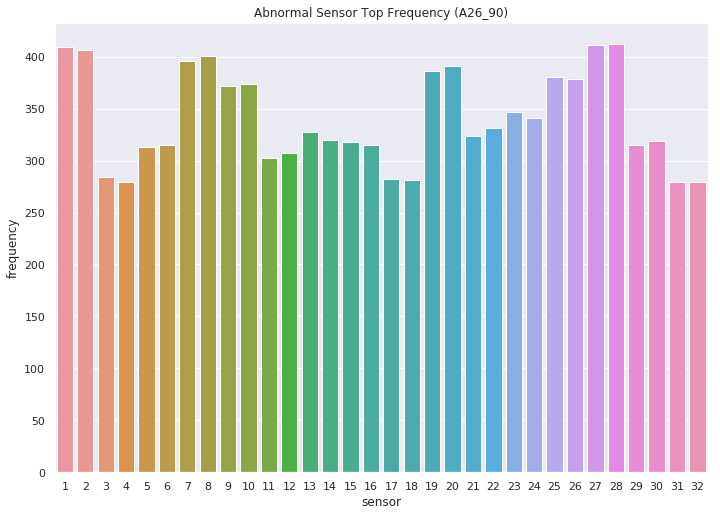

In [107]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="sensor", y="count", data=sensor_dist_a26_90)
ax.set(xlabel='sensor', ylabel='frequency', title='Abnormal Sensor Top Frequency (A26_90)')

[Text(0,0.5,'frequency'),
 Text(0.5,0,'sensor'),
 Text(0.5,1,'Abnormal Sensor Top Frequency (A12_88)')]

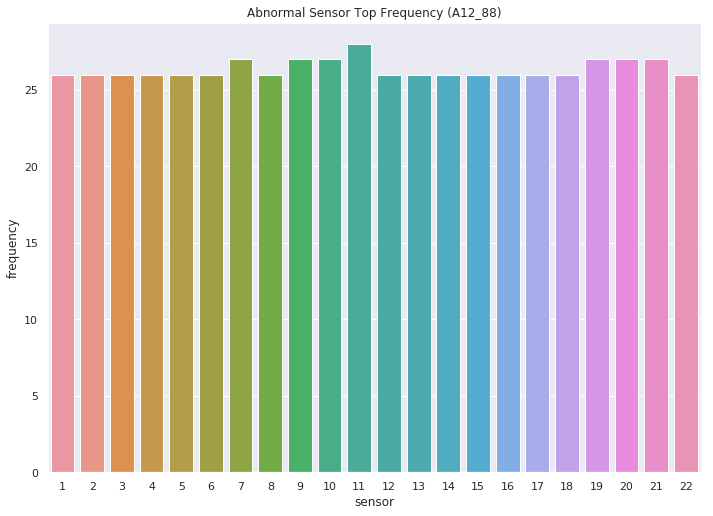

In [108]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="sensor", y="count", data=sensor_dist_a12_88)
ax.set(xlabel='sensor', ylabel='frequency', title='Abnormal Sensor Top Frequency (A12_88)')

[Text(0,0.5,'frequency'),
 Text(0.5,0,'sensor'),
 Text(0.5,1,'Abnormal Sensor Top Frequency (A26_92)')]

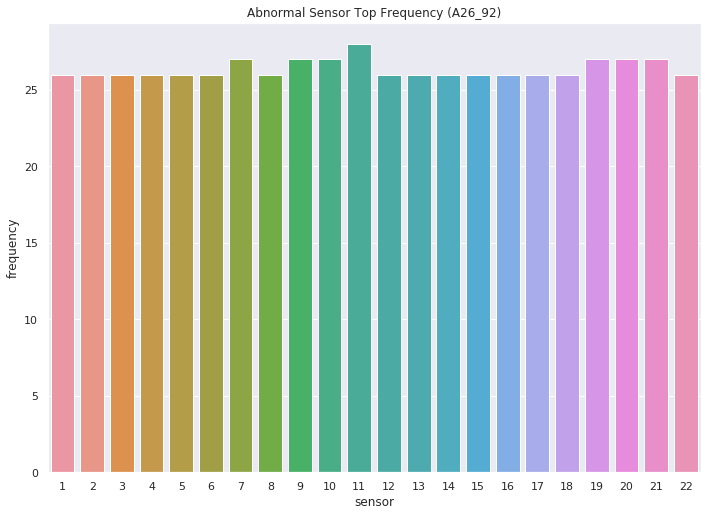

In [109]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="sensor", y="count", data=sensor_dist_a26_92)
ax.set(xlabel='sensor', ylabel='frequency', title='Abnormal Sensor Top Frequency (A26_92)')